# **Header File**

In [2]:
!pip install Biopython

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [3]:
!pip install pmdarima 

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 8.7MB 46.5MB/s 
     |████████████████████████████████| 2.1MB 34.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.18
    Uninstalling Cython-0.29.18:
      Successfully uninstalled Cython-0.29.18


In [3]:
!pip install scikit-allel

     |████████████████████████████████| 10.8MB 3.3MB/s 
  Created wheel for scikit-allel: filename=scikit_allel-1.2.1-cp36-cp36m-linux_x86_64.whl size=4780389 sha256=43315914cc1c8fa2a0be70db22a7469675173296763a735a09c2ac4f659bbc3e
  Stored in directory: /root/.cache/pip/wheels/6e/b7/6c/dcd1dea779f069333d6acc29914831cf33df76ed448f076267
Successfully built scikit-allel


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from Bio import SeqIO
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter
from sklearn.preprocessing import LabelBinarizer

# **Utility**

In [0]:
def chararray2binary(seq_array):
    encoded_array = np.zeros(shape=(seq_array.shape[0], (seq_array.shape[1]*len(alphabet))))

    for i in range(seq_array.shape[1]):
        encoded_array[:, i*len(alphabet):(i+1)*len(alphabet)] = lb.transform(seq_array[:, i])
    return encoded_array

def binary2chararray(binary_array):
    char_array = np.chararray(shape=(binary_array.shape[0], (binary_array.shape[1]/len(alphabet))), unicode=True)

    for i in range((binary_array.shape[1]/len(alphabet))):
        char_array[:, i] = lb.inverse_transform(binary_array[:, i*len(alphabet):(i+1)*len(alphabet)])
    return char_array

In [0]:
def sequence2chararray(sequences):
    char_array = np.chararray(shape=(len(sequences), 
                                     len(sequences[0])),
                                    unicode=True)
    for i, seq in enumerate(sequences):
        char_array[i, :] = list(seq)
    return char_array

def chararray2sequence(sequences):
    seq_array = []
    for i in range(len(sequences)):
        seq_array.append(''.join(sequences[i]))
    return seq_array

In [0]:
def make_encoder(training_array):
  %tensorflow_version 2.x
  !pip install --upgrade keras
  import tensorflow as tf
  from sklearn.model_selection import train_test_split
  from keras.layers import Input, Dense, Lambda, Dropout
  from keras.models import Model, model_from_json
  from keras import backend as K
  from keras import objectives
  from keras.callbacks import EarlyStopping
  # Set up VAE.
  with tf.device('/gpu:0'):

    #parameters of model
    intermediate_dim = 1000
    encoding_dim = 3
    latent_dim = encoding_dim
    epsilon_std = 1.0
    nb_epoch = 250

    x = Input(shape=(training_array.shape[1],))
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    #loss function
    def vae_loss(x, x_decoded_mean):
        xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

    #variational autoencoder
    vae = Model(x, x_decoded_mean)
    vae.compile(optimizer='adam', loss=vae_loss)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    encoder_var = Model(x, z_log_var)

    #train test split
    x_train, x_test = train_test_split(training_array)

    early_stopping = EarlyStopping(monitor="val_loss", patience=2)


    # build the decoder
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = vae.layers[-1]
    # create the decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


    # Train the VAE to learn weights
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=nb_epoch,
            validation_data=(x_test, x_test),
            callbacks=[early_stopping],
           )

  encoder.save('encoder')
  decoder.save('decoder')


In [0]:
def combine_dimensions(predictions_1,predictions_2,predictions_3): 
  temp_df = pd.DataFrame()
  temp_df['1'] = predictions_1
  temp_df['2'] = predictions_2
  temp_df['3'] = predictions_3
  return deepcopy(np.array(temp_df))

# **Driver code**

In [0]:
#sequences = [s for s in SeqIO.parse("India_aligned_sequence.fasta", "fasta")]
sequences = [s for s in SeqIO.parse("US_aligned_sequence.fasta", "fasta")]
#metadata = pd.read_csv("india_metadata.tsv", sep='\t',parse_dates=["Collection Date"])
metadata = pd.read_csv("usa_metadata.csv", parse_dates=["Collection Date"])

In [432]:
print("Shape of metadata : ",metadata.shape)
print("Total sequences in fasta file : ",len(sequences))

Shape of metadata :  (13552, 13)
Total sequences in fasta file :  13552


In [0]:
#################### Select option of India or USA

Accession_list = []
for i in range(len(sequences)):
  #for india
  #Accession_list.append(sequences[i].id[sequences[i].id.index(':')+1:sequences[i].id.index('|')])          
  #for USA
  Accession_list.append(sequences[i].id[sequences[i].id.index(':')+1:sequences[i].id.index(':',sequences[i].id.index(':')+1)])
Sequence_df = pd.DataFrame()
Sequence_df['Sequence Accession'] = Accession_list
Sequence_df['Sequence'] = [i.seq for i in sequences]

In [261]:
########################## ONLY FOR USA DATA ####################
#Sanity checks and correction
Main_df = pd.merge(metadata, Sequence_df, on='Sequence Accession')

Main_df = Main_df.drop(13551)
sequences = sequences[:-1]
Main_df = Main_df.reset_index(drop=True)
dates = Main_df['Collection Date']

for i in range(len(dates)):
  if "/" in dates[i]:
    dates[i] = datetime.strptime(dates[i], '%m/%d/%Y')
  else:
    dates[i] = datetime.strptime(dates[i], '%d-%m-%Y')

Main_df = Main_df.sort_values(by = ['Collection Date'])
Main_df = Main_df.reset_index(drop=True)

#Dataset checking and delected data if it not of our use
Main_df = Main_df[Main_df['Host Species'] == 'IRD:Human']
Main_df = Main_df[Main_df['Protein Name'] == 'HA']
Main_df = Main_df[Main_df['Subtype'] == 'H1N1']

Main_df.head(10)

,Segment,Protein Name,Sequence Accession,Complete Genome,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name,Curation Report,Sequence
0,4,HA,CY021693,Yes,1727,H1N1,2000-04-12 00:00:00,IRD:Human,USA,Tennessee,-N/A-,A/Memphis/15/2000,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
1,4,HA,MN220702,Yes,1764,H1N1,2000-04-12 00:00:00,IRD:Human,USA,Unknown,-N/A-,A/USA/rWSN/2000,Pass,"(A, T, G, A, A, G, G, C, A, A, A, A, C, T, A, ..."
2,4,HA,CY000449,Yes,1778,H1N1,2000-04-12 00:00:00,IRD:Human,USA,New York,99-00,A/New York/146/2000,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
3,4,HA,CY002640,No,1748,H1N1,2000-12-19 00:00:00,IRD:Human,USA,New York,00-01,A/New York/233/2000,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
4,4,HA,CY020141,Yes,1732,H1N1,2001-01-08 00:00:00,IRD:Human,USA,Tennessee,-N/A-,A/Memphis/6/2001,Pass,"(A, T, G, A, G, A, G, C, A, A, A, A, C, T, A, ..."
5,4,HA,CY020149,Yes,1731,H1N1,2001-01-08 00:00:00,IRD:Human,USA,Tennessee,-N/A-,A/Memphis/7/2001,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
6,4,HA,CY019875,Yes,1733,H1N1,2001-01-08 00:00:00,IRD:Human,USA,Tennessee,-N/A-,A/Memphis/8/2001,Flag-CDS,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
7,4,HA,CY020261,Yes,1745,H1N1,2001-01-08 00:00:00,IRD:Human,USA,Tennessee,-N/A-,A/Memphis/1/2001,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
8,4,HA,CY002672,Yes,1763,H1N1,2001-01-08 00:00:00,IRD:Human,USA,New York,00-01,A/New York/310/2001,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."
9,4,HA,CY001952,Yes,1754,H1N1,2001-01-08 00:00:00,IRD:Human,USA,New York,00-01,A/New York/205/2001,Pass,"(A, T, G, A, A, A, G, C, A, A, A, A, C, T, A, ..."


In [13]:
########################## ONLY FOR INDIAN DATA ####################
Main_df = pd.merge(metadata, Sequence_df, on='Sequence Accession')
Main_df = Main_df.sort_values(by = ['Collection Date'])
Main_df = Main_df.reset_index(drop=True)

#Dataset checking and delected data if it not of our use
Main_df = Main_df[Main_df['Host Species'] == 'IRD:Human']
Main_df = Main_df[Main_df['Name'] == 'HA']
Main_df = Main_df[Main_df['Subtype'] == 'H1N1']

Main_df.head(10)

,Name,Sequence Accession,Complete Genome,Segment,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name,Unnamed: 12,Sequence
0,HA,MF535113,No,4,1701,H1N1,2009-01-01,IRD:Human,India,-N/A-,-N/A-,A/Jodhpur/1316/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
1,HA,HM204566,No,4,1769,H1N1,2009-06-01,IRD:Human,India,-N/A-,-N/A-,A/Delhi/NIV57/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
2,HA,HM204567,No,4,1709,H1N1,2009-06-01,IRD:Human,India,-N/A-,-N/A-,A/Mum/NIV261/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
3,HA,CY075901,No,4,1760,H1N1,2009-06-21,IRD:Human,India,-N/A-,-N/A-,A/Pune/NIV161/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
4,HA,CY075914,No,4,1756,H1N1,2009-06-27,IRD:Human,India,-N/A-,-N/A-,A/Che/NIV246/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
5,HA,CY075913,No,4,1769,H1N1,2009-06-27,IRD:Human,India,-N/A-,-N/A-,A/Che/NIV245/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
6,HA,HM204569,No,4,1708,H1N1,2009-07-01,IRD:Human,India,-N/A-,-N/A-,A/Che/NIV658/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
7,HA,HM204570,No,4,1711,H1N1,2009-07-01,IRD:Human,India,-N/A-,-N/A-,A/Mum/NIV968/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
8,HA,HM204568,No,4,1755,H1N1,2009-07-01,IRD:Human,India,-N/A-,-N/A-,A/Pune/NIV807/2009,NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."
9,HA,CY075920,Yes,4,1756,H1N1,2009-07-07,IRD:Human,India,-N/A-,-N/A-,A/Mum/NIV398/2009(H1N1),NaN,"(-, -, -, -, -, -, -, -, -, -, -, -, -, -, -, ..."


In [19]:
alphabet = {'A', 'T', 'G', 'C', '-'}
lb = LabelBinarizer()
lb.fit(list(alphabet))
print("Unique chracters in the sequence : ",alphabet)

Unique chracters in the sequence :  {'T', 'G', 'A', '-', 'C'}


In [20]:
sequence_array = chararray2binary(sequence2chararray(sequences))
print("Shape of onehot encoding : ",sequence_array.shape)

Shape of onehot encoding :  (551, 9025)


In [0]:
#To specify from which year or month you want to split data
year = 2019
month = 1
#set grouping parameter
sampling_by = "M"

In [188]:
############################################################################
######## RUN CELL IF ENCODER AND DECODER TO BE MADE AGAIN ##################

train_index = min(Main_df[Main_df['Collection Date']>=datetime(year,month,1)].index)
training_array = sequence_array[:train_index]

make_encoder(training_array)

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


Train on 8142 samples, validate on 2715 samples
Epoch 1/250
8142/8142 [==============================] - 3s 403us/step - loss: 1431.7313 - val_loss: 557.8665
Epoch 2/250
8142/8142 [==============================] - 3s 389us/step - loss: 453.5226 - val_loss: 386.2735
Epoch 3/250
8142/8142 [==============================] - 3s 385us/step - loss: 345.5809 - val_loss: 312.5144
Epoch 4/250
8142/8142 [==============================] - 3s 383us/step - loss: 282.2156 - val_loss: 259.1229
Epoch 5/250
8142/8142 [==============================] - 3s 385us/step - loss: 241.0681 - val_loss: 227.4973
Epoch 6/250
8142/8142 [==============================] - 3s 387us/step - loss: 215.0422 - val_loss: 205.7639
Epoch 7/250
8142/8142 [==============================] - 3s 390us/step - loss: 196.2596 - val_loss: 190.7826
Epoch 8/250
8142/8142 [==============================] - 3s 385us/step - loss: 181.9535 - val_loss: 177.1672
Epoch 9/250
8142/8142 [==============================] - 3s 387us/step - loss: 

In [189]:
############ ONLY FOR TESTING #########################
from tensorflow import keras
encoder = keras.models.load_model('encoder')
decoder = keras.models.load_model('decoder')

test_array = sequence_array[train_index:train_index+10]
test_encode = encoder.predict(test_array)
test_decode = decoder.predict(test_encode)

predict_sequence = binary2chararray(test_decode)
test_sequence = sequences[train_index:train_index+10]

for i in range(10):
  positive = 0
  negative = 0
  for j in range(len(predict_sequence[i])):
    if predict_sequence[i][j] == test_sequence[i][j]:
      positive +=1
    else:
      negative +=1
  print(positive*100/(len(predict_sequence[i])))
  print(negative*100/(len(predict_sequence[i])))

99.4874715261959
0.5125284738041003
99.4874715261959
0.5125284738041003
99.4874715261959
0.5125284738041003
99.4874715261959
0.5125284738041003
99.43052391799544
0.5694760820045558
99.43052391799544
0.5694760820045558
99.43052391799544
0.5694760820045558
99.37357630979498
0.6264236902050114
99.31662870159454
0.683371298405467
99.31662870159454
0.683371298405467


In [234]:
# Load model
from tensorflow import keras
encoder = keras.models.load_model('encoder')
decoder = keras.models.load_model('decoder')
whole_encode = encoder.predict(sequence_array)
print("Model loaded successfully")

Model loaded successfully


In [235]:
#Add PCA to Main dataframe
Main_df.loc[:, 'coords0'] = whole_encode[:, 0]
Main_df.loc[:, 'coords1'] = whole_encode[:, 1]
Main_df.loc[:, 'coords2'] = whole_encode[:, 2]
print("PCA added to main dataframe")

PCA added to main dataframe


In [262]:
#Spliting into train and test data

grouping_df = deepcopy(Main_df) 
grouping_df['coord0'] = whole_encode[:, 0]
grouping_df['coord1'] = whole_encode[:, 1]
grouping_df['coord2'] = whole_encode[:, 2]


#spliting on the basis of grouing of month, quarter, day etc
grp_by_time = grouping_df.groupby('Collection Date')[['coord0', 'coord1', 'coord2']].median().resample(sampling_by).median().dropna().reset_index()

train_index = min(grp_by_time[grp_by_time['Collection Date']>=datetime(year,month,1)].index)
train_data = grp_by_time[:train_index]
test_data = grp_by_time[train_index:]
test_data = test_data.reset_index(drop=True)

#spliting PCA
train_index = min(Main_df[Main_df['Collection Date']>=datetime(year,month,1)].index)
training_PCA_all = whole_encode[:train_index]
test_PCA_all = whole_encode[train_index:]

print("Shape of train data : ",train_data.shape)
print("Shape of test data : ", test_data.shape)
print("spliting data done")

Shape of train data :  (149, 4)
Shape of test data :  (14, 4)
spliting data done


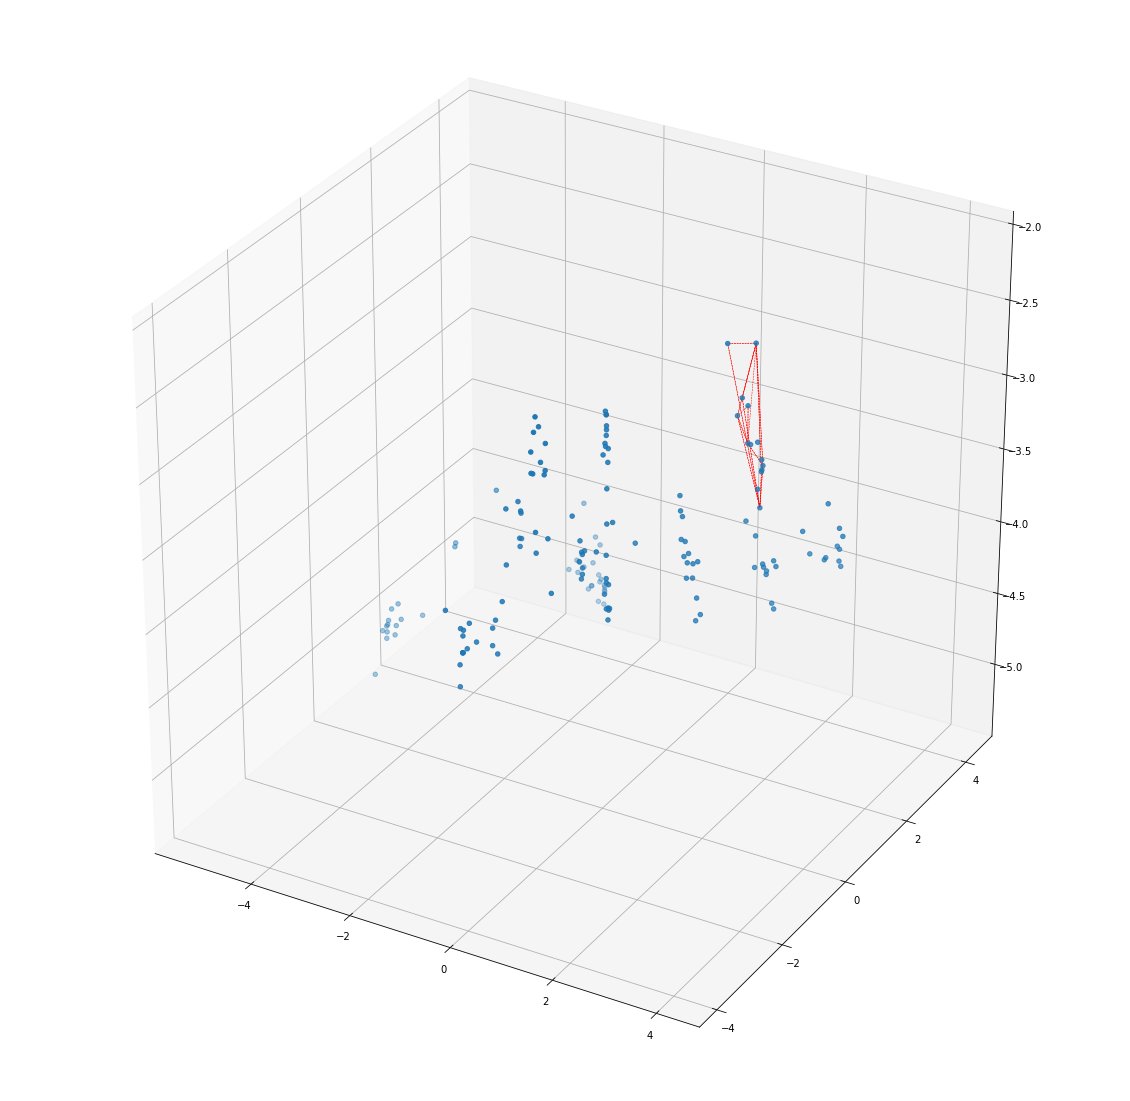

In [266]:
#Visualise test and train data
from scipy.spatial import ConvexHull
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(grp_by_time.iloc[:,1], 
           grp_by_time.iloc[:,2], 
           grp_by_time.iloc[:,3],
           cmap='viridis')

# Plot the convex hull of the test sequence
test_graph = np.array(test_data.iloc[:,[1,2,3]])
test_embeddings_hull = ConvexHull(test_graph)
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_graph[simplex, 0], 
            test_graph[simplex, 1], 
            test_graph[simplex, 2], 
            'r--', 
            lw=0.5)
ax.set_facecolor('white')
plt.show()

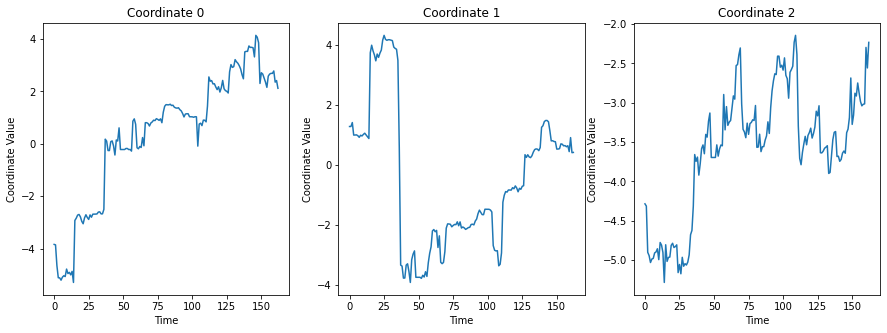

In [267]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(grp_by_time['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(grp_by_time['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(grp_by_time['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

# **ARIMA model**

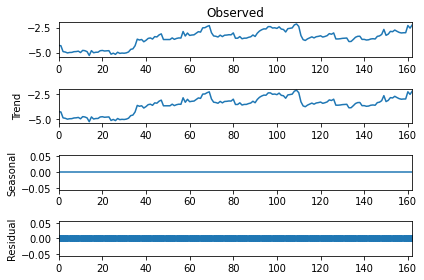

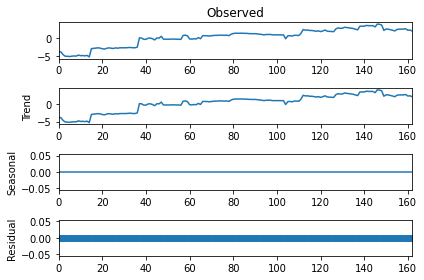

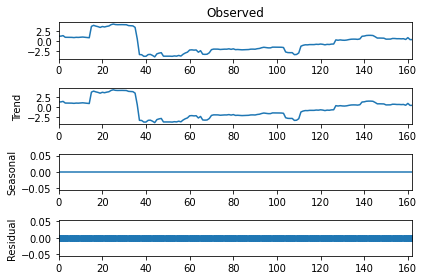

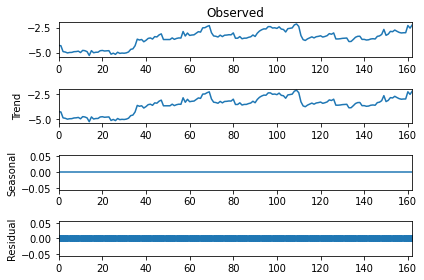

In [268]:
#Sesonality check
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_1 = seasonal_decompose(grp_by_time['coord0'].values, freq = 1)
decompose_2 = seasonal_decompose(grp_by_time['coord1'].values, freq = 1)
decompose_3 = seasonal_decompose(grp_by_time['coord2'].values, freq = 1)

decompose_1.plot()
decompose_2.plot()
decompose_3.plot()

In [272]:
from pmdarima import auto_arima 
import warnings 
warnings.filterwarnings("ignore") 
  
#for 1 dimension
stepwise_fit = auto_arima(grp_by_time['coord0'], 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 3, 
                          max_q = 3, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = False, 
                          d = None, D = 1, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True, 
                          stepwise = True)          
  
print(stepwise_fit.summary())

#for 2 dimension
stepwise_fit = auto_arima(grp_by_time['coord1'], 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 3, 
                          max_q = 3, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = False, 
                          d = None, D = 1, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True, 
                          stepwise = True)          
  
print(stepwise_fit.summary())

#for 3 dimension
stepwise_fit = auto_arima(grp_by_time['coord2'], 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 3, 
                          max_q = 3, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = False, 
                          d = None, D = 1, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True, 
                          stepwise = True)          
  
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=185.491, BIC=197.842, Time=0.240 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=185.645, BIC=191.821, Time=0.028 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=186.483, BIC=195.745, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=186.324, BIC=195.587, Time=0.039 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=184.858, BIC=187.946, Time=0.012 seconds
Total fit time: 0.369 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -91.429
Date:                Thu, 21 May 2020   AIC                            184.858
Time:                        15:22:41   BIC                            187.946
Sample:                             0   HQIC                           186.112
  

In [0]:
########################## ONLY FOR INDIAN DATA ####################
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model1 = SARIMAX(train_data['coord0'], 
				order = (0, 1, 0)) 

model2 = SARIMAX(train_data['coord1'], 
				order = (1, 0, 3)) 

model3 = SARIMAX(train_data['coord2'], 
				order = (0, 1, 0)) 

result1 = model1.fit() 
result2 = model2.fit() 
result3 = model3.fit() 

print(result1.summary())
print(result2.summary())
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                 coord0   No. Observations:                   65
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -95.911
Date:                Wed, 20 May 2020   AIC                            193.822
Time:                        20:30:30   BIC                            195.980
Sample:                             0   HQIC                           194.672
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1727      0.130      9.017      0.000       0.918       1.428
Ljung-Box (Q):                       45.30   Jarque-Bera (JB):                28.66
Prob(Q):                              0.26   Pr

In [273]:
########################## ONLY FOR USA DATA ####################
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model1 = SARIMAX(train_data['coord0'], 
				order = (0, 1, 0)) 

model2 = SARIMAX(train_data['coord1'], 
				order = (1, 1, 0)) 

model3 = SARIMAX(train_data['coord2'], 
				order = (0, 1, 0)) 

result1 = model1.fit() 
result2 = model2.fit() 
result3 = model3.fit() 

print(result1.summary())
print(result2.summary())
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                 coord0   No. Observations:                  149
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -81.836
Date:                Thu, 21 May 2020   AIC                            165.672
Time:                        15:28:49   BIC                            168.670
Sample:                             0   HQIC                           166.890
                                - 149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1769      0.007     26.485      0.000       0.164       0.190
Ljung-Box (Q):                       35.55   Jarque-Bera (JB):              1797.60
Prob(Q):                              0.67   Pr

In [0]:
prediction_time_start = 1
#### CHOOSE ACCORDING TO DATA
prediction_time_end = 14

predictions_1 = result1.predict(prediction_time_start, 
                             prediction_time_end, 
                             typ = 'levels').rename("Predictions") 
predictions_2 = result2.predict(prediction_time_start, 
                             prediction_time_end, 
                             typ = 'levels').rename("Predictions") 
predictions_3 = result3.predict(prediction_time_start, 
                             prediction_time_end, 
                             typ = 'levels').rename("Predictions")  

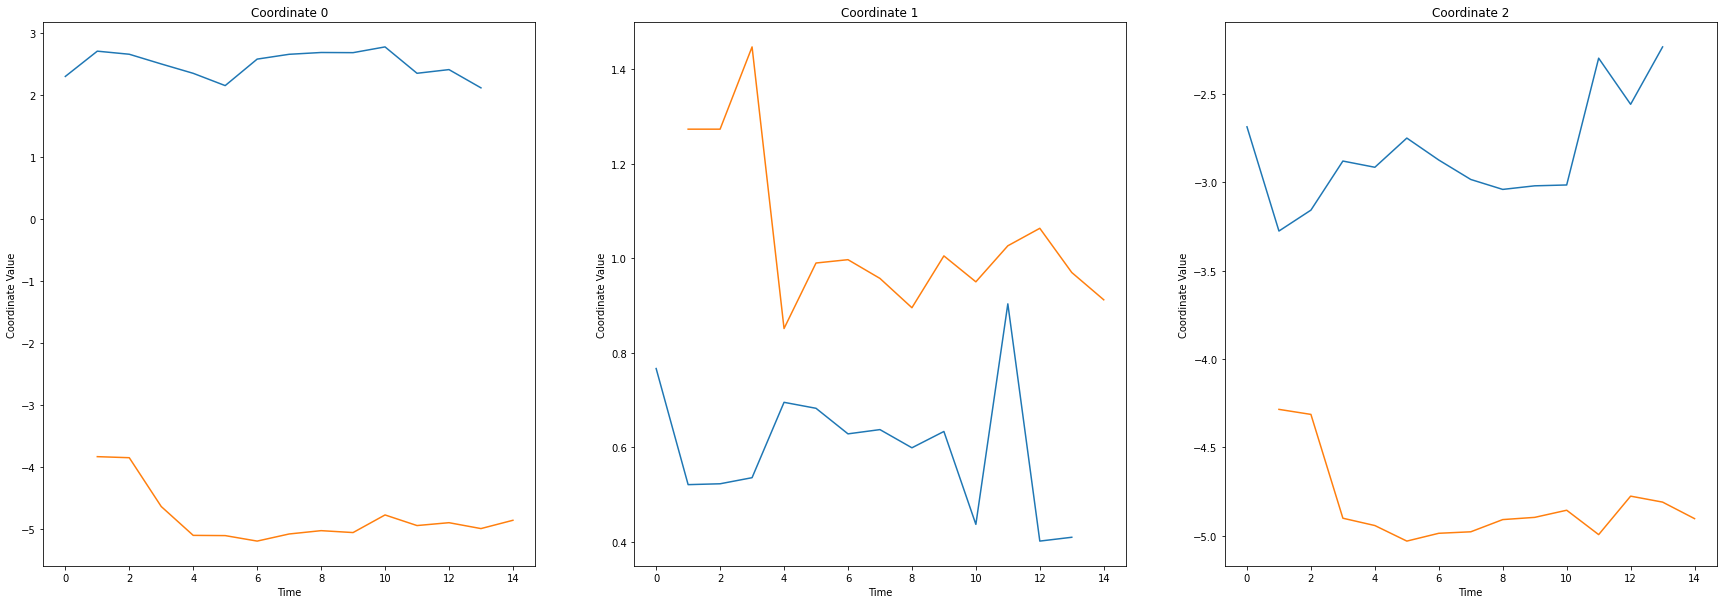

In [277]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(test_data['coord0'])
ax1.plot(predictions_1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(test_data['coord1'])
ax2.plot(predictions_2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(test_data['coord2'])
ax3.plot(predictions_3)
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

In [0]:
#making dimensions back
ARIMA_prediction = combine_dimensions(predictions_1,
                                      predictions_2,
                                      predictions_3)

ARIMA_Sequence = binary2chararray(decoder.predict(ARIMA_prediction))

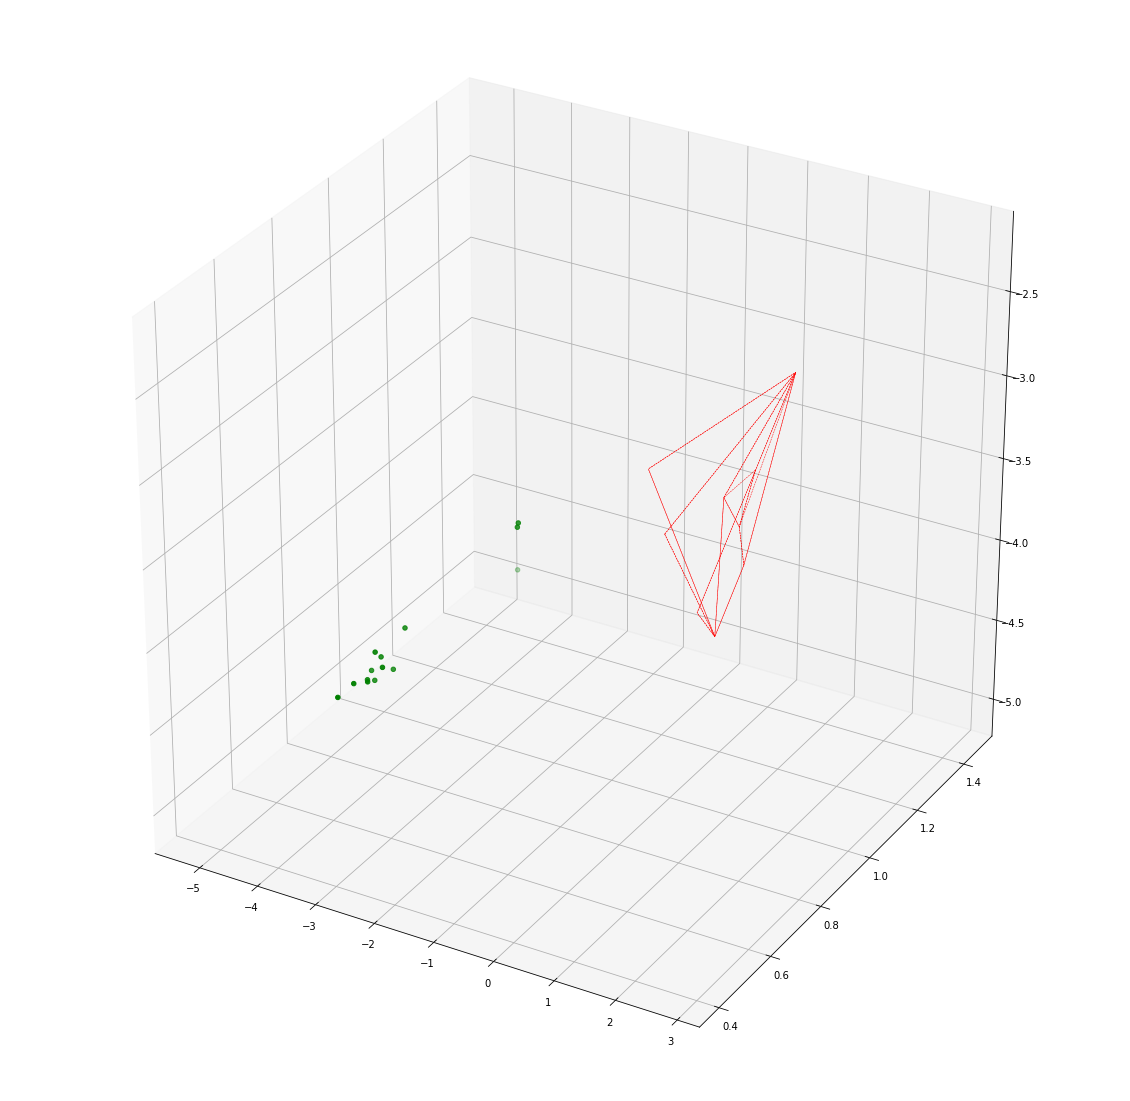

In [349]:
#Visualise test and prediction data
from scipy.spatial import ConvexHull
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(predictions_1,
           predictions_2,
           predictions_3,
           c='g')

# Plot the convex hull of the test sequence
test_graph = np.array(test_data.iloc[:,[1,2,3]])
test_embeddings_hull = ConvexHull(test_graph)
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_graph[simplex, 0], 
            test_graph[simplex, 1], 
            test_graph[simplex, 2], 
            'r--', 
            lw=0.5)
ax.set_facecolor('white')
plt.show()

# **Neural Network**

In [0]:
def window_dataset(series,window_size,batch_size=16,shuffle_buffer=1000):
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda window: window.batch(window_size+1))
  #ds=ds.shuffle(shuffle_buffer)
  ds=ds.map(lambda window: (window[:-1],window[-1]))
  ds=ds.batch(batch_size).prefetch(1)
  count=0
  return ds

In [0]:
training_PCA = np.array(train_data.iloc[:,[1,2,3]])
test_PCA = np.array(test_data.iloc[:,[1,2,3]])

In [0]:
import tensorflow as tf

window_size = 5

t_data=training_PCA.transpose() # to get whole train data as one row
v_data=test_PCA.transpose()

model1_train=t_data[0]
model2_train=t_data[1]
model3_train=t_data[2]

model1_val=v_data[0]
model2_val=v_data[1]
model3_val=v_data[2]

In [298]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model1_train_set = window_dataset(model1_train, window_size)
model1_val_set = window_dataset(model1_val, window_size)

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model1.fit(model1_train_set, 
          epochs=500,
          validation_data=model1_val_set,
          callbacks=[early_stopping],
          verbose = False)

In [299]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2_train_set = window_dataset(model2_train, window_size)
model2_val_set = window_dataset(model2_val, window_size)

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model2.fit(model2_train_set, 
          epochs=500,
          validation_data=model2_val_set,
          callbacks=[early_stopping],
          verbose = False)

In [300]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model3_train_set = window_dataset(model3_train, window_size)
model3_val_set = window_dataset(model3_val, window_size)

model3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model3.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model3.fit(model3_train_set, 
          epochs=500,
          validation_data=model3_val_set,
          callbacks=[early_stopping],
          verbose = False)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(16).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
testing_batch = np.array((grp_by_time[-(len(test_PCA)+4):]).iloc[:,[1,2,3]])

In [368]:
model1_forecast = model_forecast(model1, testing_batch.transpose()[0], window_size)
model2_forecast = model_forecast(model2, testing_batch.transpose()[1], window_size)
model3_forecast = model_forecast(model3, testing_batch.transpose()[2], window_size)

error1 = np.sum(tf.keras.metrics.mean_absolute_error(model1_val, model1_forecast).numpy())
error2 = np.sum(tf.keras.metrics.mean_absolute_error(model2_val, model2_forecast).numpy())
error3 = np.sum(tf.keras.metrics.mean_absolute_error(model3_val, model3_forecast).numpy())

print("Error in the model")
print(error1)
print(error2)
print(error3)
print("Total error : ",((error1+error2+error3)/3))

Error in the model
3.964169
3.6440146
4.183976
Total error :  3.930720011393229


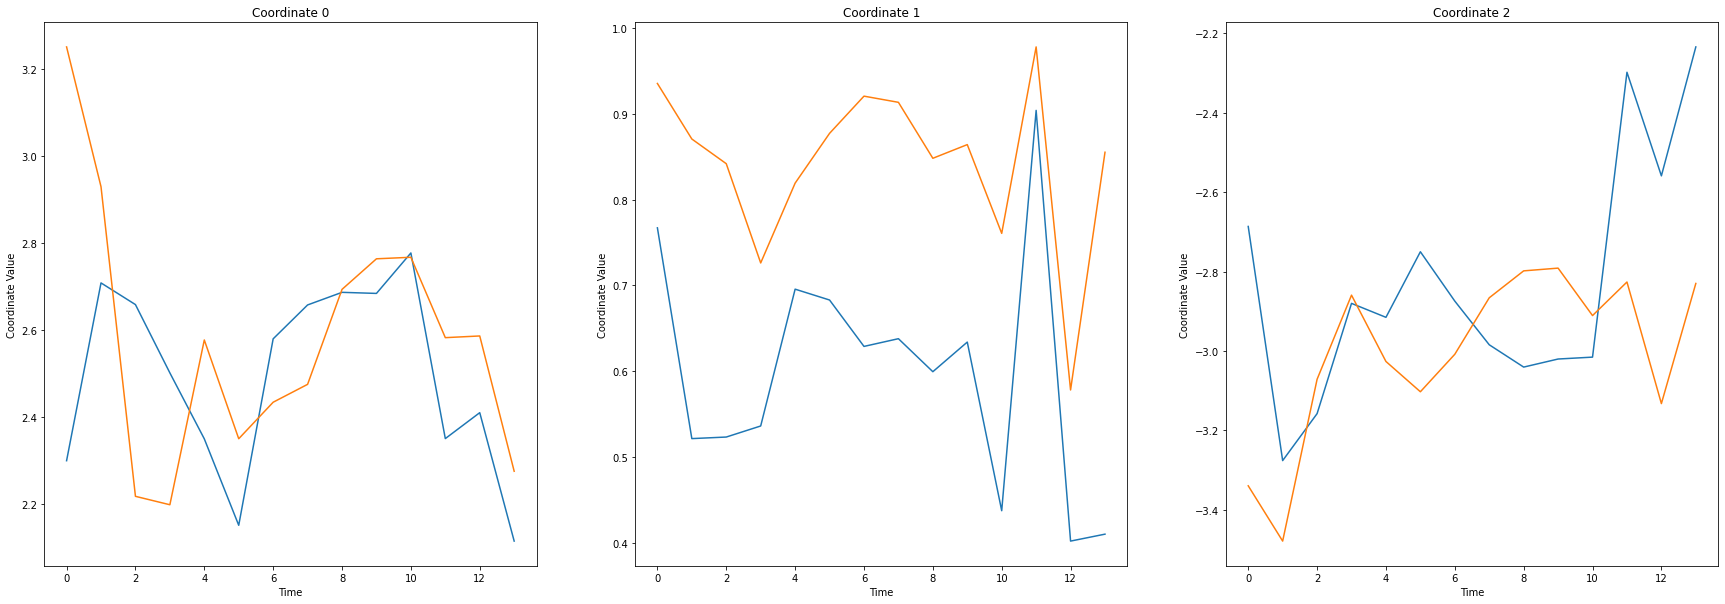

In [370]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(test_PCA.transpose()[0])
ax1.plot(model1_forecast)
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(test_PCA.transpose()[1])
ax2.plot(model2_forecast)
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(test_PCA.transpose()[2])
ax3.plot(model3_forecast)
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

In [0]:
#making dimensions back
NEURAL_prediction = combine_dimensions(model1_forecast.flatten(),
                                        model2_forecast.flatten(),
                                        model3_forecast.flatten())

NEURAL_Sequence = binary2chararray(decoder.predict(NEURAL_prediction))

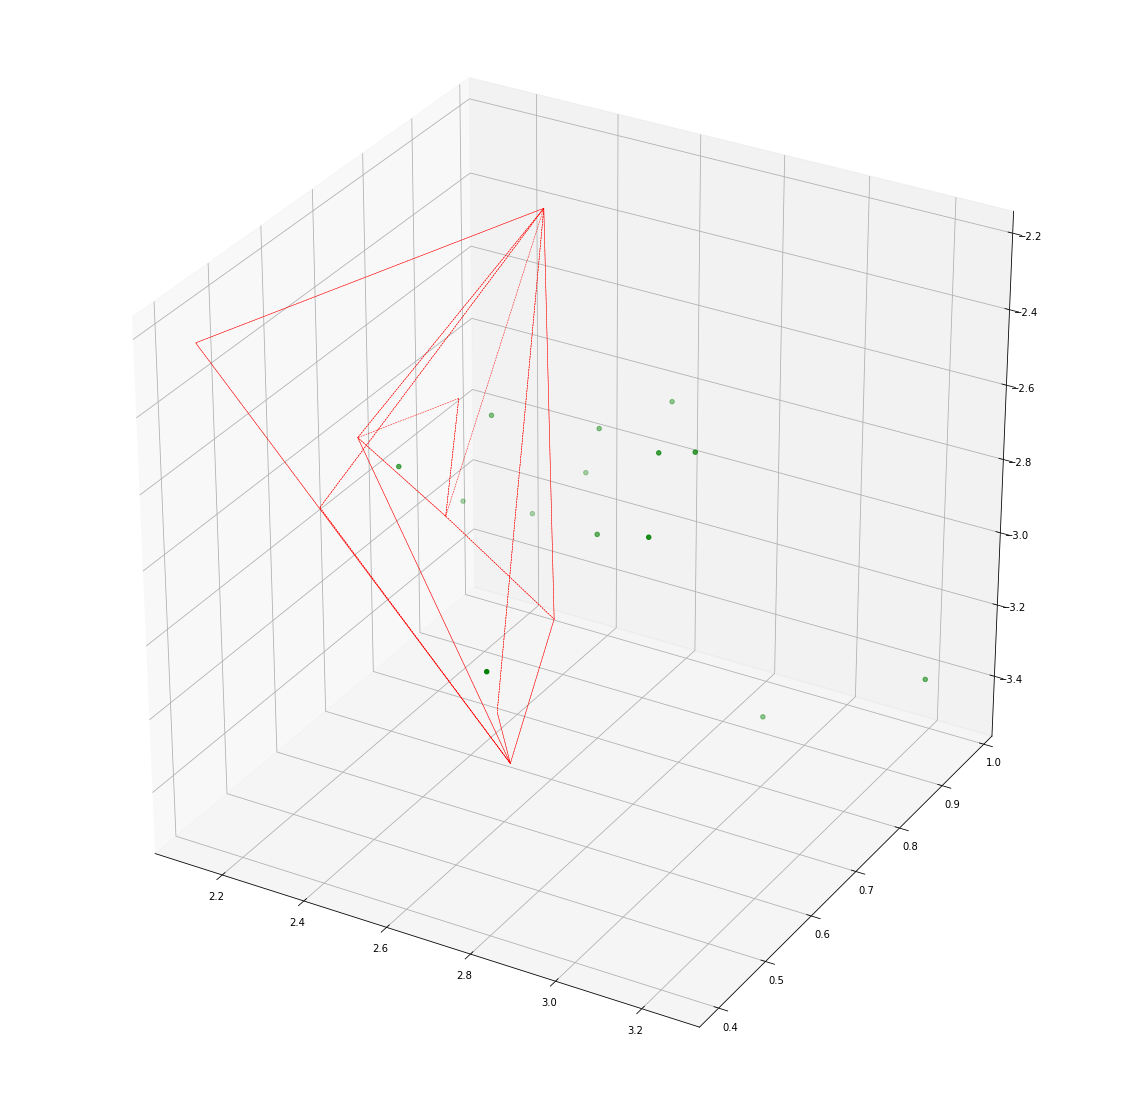

In [372]:
#Visualise test and prediction data
from scipy.spatial import ConvexHull
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(model1_forecast.flatten(),
           model2_forecast.flatten(),
           model3_forecast.flatten(),
           c='g')

# Plot the convex hull of the test sequence
test_graph = np.array(test_data.iloc[:,[1,2,3]])
test_embeddings_hull = ConvexHull(test_graph)
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_graph[simplex, 0], 
            test_graph[simplex, 1], 
            test_graph[simplex, 2], 
            'r--', 
            lw=0.5)
ax.set_facecolor('white')
plt.show()

In [0]:
model1_forecast = model_forecast(model1, testing_batch.transpose()[0], window_size)
model2_forecast = model_forecast(model2, testing_batch.transpose()[1], window_size)
model3_forecast = model_forecast(model3, testing_batch.transpose()[2], window_size)

In [0]:
first_batch = (testing_batch.transpose()[0][-5:])
second_batch = (testing_batch.transpose()[1][-5:])
third_batch = (testing_batch.transpose()[2][-5:])

In [0]:
model1_forecast = model1_forecast.flatten()
model2_forecast = model2_forecast.flatten()
model3_forecast = model3_forecast.flatten()

In [0]:
more_result = 34
for i in range(more_result):
  result = (model_forecast(model1, first_batch[-5:], window_size))
  first_batch = np.append(first_batch,result[0][0])
  model1_forecast = np.append(model1_forecast,result[0][0])

for i in range(more_result):
  result = (model_forecast(model2, second_batch[-5:], window_size))
  first_batch = np.append(second_batch,result[0][0])
  model2_forecast = np.append(model2_forecast, result[0][0])

for i in range(more_result):
  result = (model_forecast(model3, third_batch[-5:], window_size))
  first_batch = np.append(second_batch,result[0][0])
  model3_forecast = np.append(model3_forecast, result[0][0])

In [0]:
#making dimensions back
NEURAL_prediction = combine_dimensions(model1_forecast,
                                        model2_forecast,
                                        model3_forecast)

NEURAL_Sequence = binary2chararray(decoder.predict(NEURAL_prediction))

# **LSTM**

In [0]:
keras=tf.keras
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(16).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [284]:
### PREDICITION MODEL #######

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#model2_train_set = window_dataset(model2_train, window_size)
#model2_val_set = window_dataset(model2_val, window_size)
lstm_m1_train_set = seq2seq_window_dataset(model1_train, window_size,
                                   batch_size=16)
lstm_m1_valid_set = seq2seq_window_dataset(model1_val, window_size,
                                   batch_size=16)

model1 = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 20) #####Choose Scaling FACTOR
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model1.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "model1_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model1.fit(lstm_m1_train_set, epochs=1000,
          validation_data=lstm_m1_valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
10/10 [==============================] - 1s 86ms/step - loss: 1.8678 - mae: 2.3014 - val_loss: 1.0856 - val_mae: 1.5752
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.6785 - mae: 2.0805 - val_loss: 0.7697 - val_mae: 1.2274
Epoch 3/1000
10/10 [==============================] - 0s 12ms/step - loss: 1.4854 - mae: 1.8746 - val_loss: 0.7691 - val_mae: 1.1973
Epoch 4/1000
10/10 [==============================] - 0s 10ms/step - loss: 1.3131 - mae: 1.7069 - val_loss: 0.8831 - val_mae: 1.3111
Epoch 5/1000
10/10 [==============================] - 0s 12ms/step - loss: 1.1403 - mae: 1.5267 - val_loss: 0.7181 - val_mae: 1.1253
Epoch 6/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.9965 - mae: 1.3809 - val_loss: 0.7670 - val_mae: 1.1763
Epoch 7/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.8686 - mae: 1.2590 - val_loss: 0.7595 - val_mae: 1.1695
Epoch 8/1000
10/10 [==============================] - 0s 10ms/step - 

In [285]:
### PREDICITION MODEL #######

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#model2_train_set = window_dataset(model2_train, window_size)
#model2_val_set = window_dataset(model2_val, window_size)
lstm_m2_train_set = seq2seq_window_dataset(model2_train, window_size,
                                   batch_size=16)
lstm_m2_valid_set = seq2seq_window_dataset(model2_val, window_size,
                                   batch_size=16)

model2 = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 20) #####Choose Scaling FACTOR
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model2.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "model2_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model2.fit(lstm_m2_train_set, epochs=500,
          validation_data=lstm_m2_valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
10/10 [==============================] - 1s 87ms/step - loss: 1.9665 - mae: 2.4540 - val_loss: 0.5022 - val_mae: 0.9965
Epoch 2/500
10/10 [==============================] - 0s 11ms/step - loss: 1.6441 - mae: 2.1134 - val_loss: 1.3253 - val_mae: 1.8086
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 1.4106 - mae: 1.8621 - val_loss: 1.4415 - val_mae: 1.9287
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 1.2125 - mae: 1.6551 - val_loss: 0.9463 - val_mae: 1.4315
Epoch 5/500
10/10 [==============================] - 0s 12ms/step - loss: 1.0121 - mae: 1.4595 - val_loss: 0.4696 - val_mae: 0.9450
Epoch 6/500
10/10 [==============================] - 0s 10ms/step - loss: 0.8596 - mae: 1.2841 - val_loss: 0.5483 - val_mae: 1.0263
Epoch 7/500
10/10 [==============================] - 0s 11ms/step - loss: 0.7343 - mae: 1.1345 - val_loss: 0.4059 - val_mae: 0.8351
Epoch 8/500
10/10 [==============================] - 0s 11ms/step - loss: 0.

In [286]:
### PREDICITION MODEL #######

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#model2_train_set = window_dataset(model2_train, window_size)
#model2_val_set = window_dataset(model2_val, window_size)
lstm_m3_train_set = seq2seq_window_dataset(model3_train, window_size,
                                   batch_size=16)
lstm_m3_valid_set = seq2seq_window_dataset(model3_val, window_size,
                                   batch_size=16)

model3 = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.LSTM(16, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 20) #####Choose Scaling FACTOR
])
optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model3.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "model3_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model3.fit(lstm_m3_train_set, epochs=500,
          validation_data=lstm_m3_valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
10/10 [==============================] - 1s 85ms/step - loss: 2.2995 - mae: 2.7736 - val_loss: 0.1240 - val_mae: 0.4353
Epoch 2/500
10/10 [==============================] - 0s 11ms/step - loss: 1.2414 - mae: 1.7020 - val_loss: 0.8849 - val_mae: 1.3675
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 0.6088 - mae: 1.0081 - val_loss: 0.8873 - val_mae: 1.3803
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 0.4497 - mae: 0.8420 - val_loss: 0.3454 - val_mae: 0.7347
Epoch 5/500
10/10 [==============================] - 0s 10ms/step - loss: 0.3734 - mae: 0.7448 - val_loss: 0.1484 - val_mae: 0.4469
Epoch 6/500
10/10 [==============================] - 0s 12ms/step - loss: 0.3685 - mae: 0.7313 - val_loss: 0.1089 - val_mae: 0.3897
Epoch 7/500
10/10 [==============================] - 0s 10ms/step - loss: 0.2682 - mae: 0.6078 - val_loss: 0.3489 - val_mae: 0.7591
Epoch 8/500
10/10 [==============================] - 0s 10ms/step - loss: 0.

In [287]:
model1 = keras.models.load_model("model1_checkpoint.h5")
model2 = keras.models.load_model("model2_checkpoint.h5")
model3 = keras.models.load_model("model3_checkpoint.h5")
series1=test_PCA.transpose()[0]
series2=test_PCA.transpose()[1]
series3=test_PCA.transpose()[2]
lstm_m1_forecast = model_forecast(model1, series1[:,np.newaxis], window_size)
lstm_m2_forecast = model_forecast(model2, series2[:,np.newaxis], window_size)
lstm_m3_forecast = model_forecast(model3, series3[:,np.newaxis], window_size)

error1 = np.sum(tf.keras.metrics.mean_absolute_error(model1_val, lstm_m1_forecast).numpy())
error2 = np.sum(tf.keras.metrics.mean_absolute_error(model2_val, lstm_m2_forecast).numpy())
error3 = np.sum(tf.keras.metrics.mean_absolute_error(model3_val, lstm_m3_forecast).numpy())

print("Error in the model")
print(error1)
print(error2)
print(error3)
print("Mean error : ",((error1+error2+error3)/3))

<class 'numpy.ndarray'>
Error in the model
50.87138
54.99515
45.657143
Mean error :  50.507893880208336


In [289]:
lstm_m1_forecast.shape

(20, 5, 1)

# **SNP integration**

In [0]:
import allel

vcf = allel.read_vcf('output.vcf')
SNP_pos = vcf['variants/POS']

In [0]:
############# ARIMA + SNP ################
base_sequence = sequences[train_index].seq
prediction_length = 48
sequences_length = 1756

ARIMA_SNP_forecast_sequence = []
for months in range(prediction_length):
  temp = []
  for iter in range(sequences_length):
    if iter in SNP_pos:
      temp.append(ARIMA_Sequence[month][iter])
    else:
      temp.append(base_sequence[iter])
  ARIMA_SNP_forecast_sequence.append(''.join(temp))

In [354]:
len(NEURAL_Sequence)

15

In [0]:
############# Neural + SNP ################
base_sequence = sequences[train_index].seq
prediction_length = 48
sequences_length = 1756

Neural_SNP_forecast_sequence = []
for months in range(prediction_length):
  temp = []
  for iter in range(sequences_length):
    if iter in SNP_pos:
      temp.append(NEURAL_Sequence[month][iter])
    else:
      temp.append(base_sequence[iter])
  Neural_SNP_forecast_sequence.append(''.join(temp))

In [0]:
with open("ARIMA_SNP.txt", "w") as txt_file:
    for line in ARIMA_SNP_forecast_sequence:
        txt_file.write(line + "\n")

In [0]:
with open("ARIMA.txt", "w") as txt_file:
    for line in ARIMA_Sequence:
        txt_file.write(''.join(line) + "\n")

In [0]:
with open("Neural_SNP.txt", "w") as txt_file:
    for line in Neural_SNP_forecast_sequence:
        txt_file.write(line + "\n")

In [0]:
with open("Neural.txt", "w") as txt_file:
    for line in NEURAL_Sequence:
        txt_file.write(''.join(line) + "\n")